In [ ]:
import numpy as np
from pathlib import Path
import tensorflow as tf
import sys
import os
from datetime import datetime

from sklearn.metrics import classification_report
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import (
    auc,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
trainpath = '/content/pred.npz'
valpath = '/content/val.npz'
testpath = '/content/test.npz'

In [ ]:
BATCH_SIZE = 128
TEST_BATCH_SIZE = 28
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 128
limit=None
print('Train Loading')
with np.load(trainpath, allow_pickle=True) as data:
    train_examples = data['x'][:limit]
    train_labels = (data['y'][:limit]).astype(np.int64)

train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(8)
print('Train Loaded')

print('Val Loading')
with np.load(valpath, allow_pickle=True) as data:
    val_examples = data['x']
    val_labels = (data['y']).astype(np.int64)

val_dataset = tf.data.Dataset.from_tensor_slices((val_examples, val_labels)).prefetch(8)
val_dataset = val_dataset.batch(BATCH_SIZE)
print('Val Loaded')


print('Test Loading')
with np.load(testpath, allow_pickle=True) as data:
    test_examples = data['x']
    test_labels = (data['y']).astype(np.int64)

test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels)).prefetch(8)
test_dataset = test_dataset.batch(TEST_BATCH_SIZE)
print('Test Loaded')

Train Loading
Train Loaded
Val Loading
Val Loaded
Test Loading
Test Loaded


In [ ]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_data = train_dataset.with_options(options)
val_dataset = val_dataset.with_options(options)
test_dataset = test_dataset.with_options(options)

In [ ]:
print("Creating a model")
tf.keras.backend.set_floatx('float64')

Creating a model


In [ ]:
strategy = tf.distribute.MirroredStrategy

In [ ]:


    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(128, 4)),
        tf.keras.layers.LayerNormalization(
            axis=1, epsilon=1e-10, center=True, scale=True,
            beta_initializer='zeros', gamma_initializer='ones',
        ),
        
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=False)),
        
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(128, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(32, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(1)
    ])
    model.load_weights('/content/model.ckpt')

    regularizer = tf.keras.regularizers.l1(0.01)
    for layer in model.layers:
     for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

    model.compile(optimizer=tf.keras.optimizers.SGD(),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = ['accuracy'])
    





   

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/model.ckpt',
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True)

In [ ]:
model.load_weights('/content/model.ckpt')

In [ ]:
    print("Model Evaluation Started")
    
    y_prob = tf.sigmoid(model.predict(test_examples))
    #y_out = (y_prob > 0.84).numpy().astype("int32")
    y_out = (y_prob > 0.5).numpy().astype("int32")
    target_names = ['No-Fall', 'Fall']
    report = classification_report(test_labels, y_out, target_names=target_names, zero_division = 0)
    
    # with open(f"{rep_root}/test_report_version_{version_catalog}.txt","w") as f:
    #     f.write(report)
    print(report)

Model Evaluation Started
              precision    recall  f1-score   support

     No-Fall       0.51      0.57      0.54       406
        Fall       0.49      0.44      0.46       394

    accuracy                           0.50       800
   macro avg       0.50      0.50      0.50       800
weighted avg       0.50      0.50      0.50       800



In [ ]:
test_labels 

In [ ]:
y_out

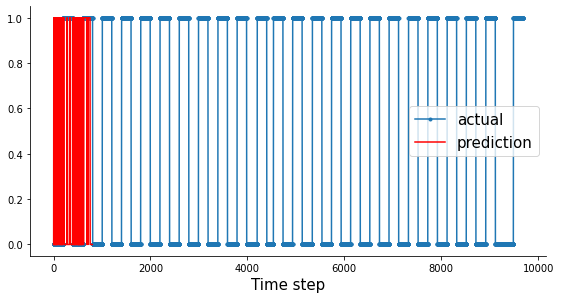

In [ ]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( val_labels, marker='.', label="actual")
plt.plot(y_out, 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
    print("Model Evaluation Started")
    
    y_prob = tf.sigmoid(model.predict(val_examples))
    #y_out = (y_prob > 0.84).numpy().astype("int32")
    y_out = (y_prob > 0.5).numpy().astype("int32")
    target_names = ['No-Fall', 'Fall']
    report = classification_report(val_labels, y_out, target_names=target_names, zero_division = 0)
    
    # with open(f"{rep_root}/test_report_version_{version_catalog}.txt","w") as f:
    #     f.write(report)
    print(report)

Model Evaluation Started


KeyboardInterrupt: ignored